# 1. Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

all_train_size = len(train_data)
little_train_size = int(0.8 * all_train_size)
val_size = all_train_size - little_train_size

little_train_dataset, val_dataset = random_split(train_data, [little_train_size, val_size])

little_train_dataloader = DataLoader(little_train_dataset,batch_size=batch_size,
    shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
train_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [4]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(little_train_dataset, [subset_size, little_train_size  - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [4]:
for images, labels in little_train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Model

In [5]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

# 4. Training

In [6]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
            
    print('Finished training!')
    return loss_history

In [7]:
model_1 = Fcnn()
epochs = 8
optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.CrossEntropyLoss()

loss_history_1 = train(epochs, model_1, optimizer, criterion, little_train_dataloader)

c:\Users\Komputer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 1.7551
epoch: 1, step: 200/750, loss: 1.7521
epoch: 1, step: 300/750, loss: 1.6713
epoch: 1, step: 400/750, loss: 1.6650
epoch: 1, step: 500/750, loss: 1.6125
epoch: 1, step: 600/750, loss: 1.7263
epoch: 1, step: 700/750, loss: 1.6521
epoch: 2, step: 100/750, loss: 1.5841
epoch: 2, step: 200/750, loss: 1.5871
epoch: 2, step: 300/750, loss: 1.5459
epoch: 2, step: 400/750, loss: 1.5912
epoch: 2, step: 500/750, loss: 1.5367
epoch: 2, step: 600/750, loss: 1.5696
epoch: 2, step: 700/750, loss: 1.5383
epoch: 3, step: 100/750, loss: 1.5850
epoch: 3, step: 200/750, loss: 1.5788
epoch: 3, step: 300/750, loss: 1.5134
epoch: 3, step: 400/750, loss: 1.5680
epoch: 3, step: 500/750, loss: 1.5211
epoch: 3, step: 600/750, loss: 1.5752
epoch: 3, step: 700/750, loss: 1.4988
epoch: 4, step: 100/750, loss: 1.5504
epoch: 4, step: 200/750, loss: 1.5668
epoch: 4, step: 300/750, loss: 1.5348
epoch: 4, step: 400/750, loss: 1.4934
epoch: 4, step: 500/750, loss: 1.5098
epoch: 4, st

# 5. Testing

In [7]:
def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [9]:
accuracy_1 = test(model_1, test_dataloader)

Accuracy: 0.951


# 6. Weight initialization

## 6.1 Large weights

In [10]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3025
epoch: 1, step: 200/750, loss: 2.3024
epoch: 1, step: 300/750, loss: 2.3025
epoch: 1, step: 400/750, loss: 2.3033
epoch: 1, step: 500/750, loss: 2.3020
epoch: 1, step: 600/750, loss: 2.3014
epoch: 1, step: 700/750, loss: 2.3019
epoch: 2, step: 100/750, loss: 2.3009
epoch: 2, step: 200/750, loss: 2.2990
epoch: 2, step: 300/750, loss: 2.3019
epoch: 2, step: 400/750, loss: 2.3015
epoch: 2, step: 500/750, loss: 2.2996
epoch: 2, step: 600/750, loss: 2.3031
epoch: 2, step: 700/750, loss: 2.3028
epoch: 3, step: 100/750, loss: 2.3015
epoch: 3, step: 200/750, loss: 2.3022
epoch: 3, step: 300/750, loss: 2.3002
epoch: 3, step: 400/750, loss: 2.3045
epoch: 3, step: 500/750, loss: 2.3032
epoch: 3, step: 600/750, loss: 2.3040
epoch: 3, step: 700/750, loss: 2.2938
epoch: 4, step: 100/750, loss: 2.3017
epoch: 4, step: 200/750, loss: 2.2933
epoch: 4, step: 300/750, loss: 2.3027
epoch: 4, step: 400/750, loss: 2.3004
epoch: 4, step: 500/750, loss: 2.2967
epoch: 4, st

In [11]:
accuracy_2 = test(model_2, test_dataloader)

Accuracy: 0.113


## 6.2 All weights set to 1

In [12]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3025
epoch: 1, step: 200/750, loss: 2.3027
epoch: 1, step: 300/750, loss: 2.3030
epoch: 1, step: 400/750, loss: 2.3022
epoch: 1, step: 500/750, loss: 2.3018
epoch: 1, step: 600/750, loss: 2.3019
epoch: 1, step: 700/750, loss: 2.3025
epoch: 2, step: 100/750, loss: 2.3040
epoch: 2, step: 200/750, loss: 2.3032
epoch: 2, step: 300/750, loss: 2.3026
epoch: 2, step: 400/750, loss: 2.2996
epoch: 2, step: 500/750, loss: 2.3020
epoch: 2, step: 600/750, loss: 2.3015
epoch: 2, step: 700/750, loss: 2.3043
epoch: 3, step: 100/750, loss: 2.2983
epoch: 3, step: 200/750, loss: 2.2971
epoch: 3, step: 300/750, loss: 2.3029
epoch: 3, step: 400/750, loss: 2.2998
epoch: 3, step: 500/750, loss: 2.3005
epoch: 3, step: 600/750, loss: 2.3057
epoch: 3, step: 700/750, loss: 2.3015
epoch: 4, step: 100/750, loss: 2.2981
epoch: 4, step: 200/750, loss: 2.2951
epoch: 4, step: 300/750, loss: 2.2995
epoch: 4, step: 400/750, loss: 2.2980
epoch: 4, step: 500/750, loss: 2.2942
epoch: 4, st

In [13]:
accuracy_3 = test(model_3, test_dataloader)

Accuracy: 0.113


## 6.3 Results

C:\Users\Komputer\AppData\Local\Temp\ipykernel_14892\306140487.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


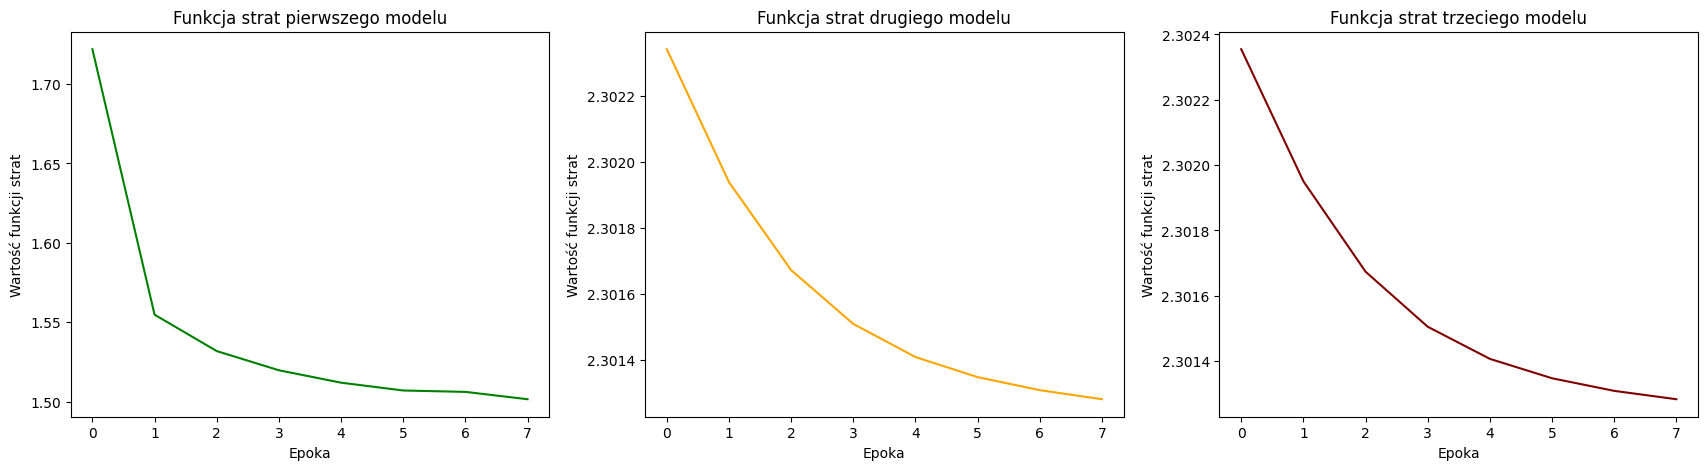

In [14]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

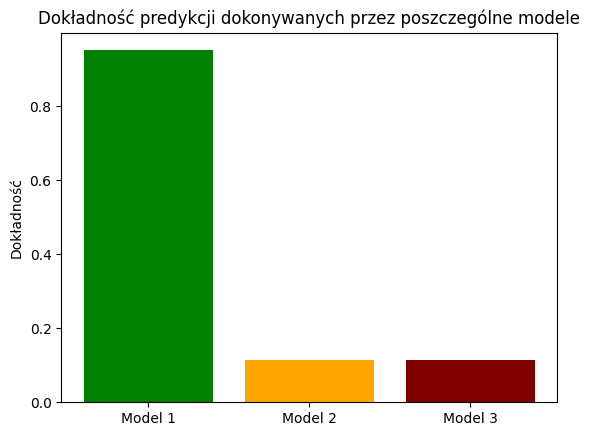

In [15]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')
plt.ylabel('Dokładność')

plt.show()

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 7. Training on subsets of different sizes

In [18]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(3,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,val_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

Finished training!
Accuracy: 0.674
Accuracy: 0.654
Finished training!
Accuracy: 0.707
Accuracy: 0.696
Finished training!
Accuracy: 0.734
Accuracy: 0.720
Finished training!
Accuracy: 0.820
Accuracy: 0.808
Finished training!
Accuracy: 0.815
Accuracy: 0.809


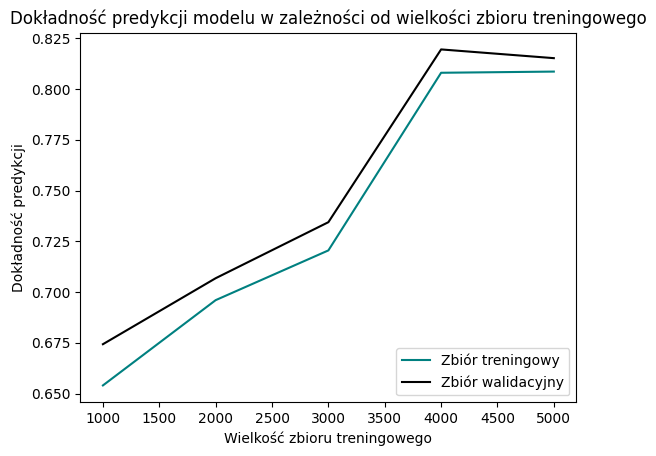

In [19]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór treningowy', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór walidacyjny', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

# 8. Early stopping

In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        print(self.min_validation_loss,validation_loss,validation_loss  > (self.min_validation_loss  + self.min_delta))
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
         
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion,dataloader):
    early_stopper = EarlyStopper(patience=3)
    model.train()
    for epoch in range(epochs):
        batch_loss_history = []
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(dataloader)} , loss: {loss.item():.4f}')
            batch_loss_history.append(loss.item())
        
        epoch_avg_loss = np.average(batch_loss_history)

        print(f'Epoch: {epoch+1}, avg_loss = {epoch_avg_loss}')
        if early_stopper.early_stop(epoch_avg_loss):
            print('Early stopping!')
            break
        
    print('Finished training!')



In [21]:
epochs = 35

model_4 = Fcnn()
learning_rate = 1
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)

train_es(epochs, model_4, optimizer, criterion, dataloader=train_dataloader)

epoch: 1, step: 100/157 , loss: 1.9798
Epoch: 1, avg_loss = 2.001776066555339
inf 2.001776066555339 False
epoch: 2, step: 100/157 , loss: 1.6878
Epoch: 2, avg_loss = 1.7410684603794364
2.001776066555339 1.7410684603794364 False
epoch: 3, step: 100/157 , loss: 1.6976
Epoch: 3, avg_loss = 1.6457633433068635
1.7410684603794364 1.6457633433068635 False
epoch: 4, step: 100/157 , loss: 1.6524
Epoch: 4, avg_loss = 1.6220722995745909
1.6457633433068635 1.6220722995745909 False
epoch: 5, step: 100/157 , loss: 1.6100
Epoch: 5, avg_loss = 1.615658341699345
1.6220722995745909 1.615658341699345 False
epoch: 6, step: 100/157 , loss: 1.7559
Epoch: 6, avg_loss = 1.6808992069997606
1.615658341699345 1.6808992069997606 True
epoch: 7, step: 100/157 , loss: 1.5742
Epoch: 7, avg_loss = 1.6360906704216247
1.615658341699345 1.6360906704216247 True
epoch: 8, step: 100/157 , loss: 1.5396
Epoch: 8, avg_loss = 1.609494409743388
1.615658341699345 1.609494409743388 False
epoch: 9, step: 100/157 , loss: 1.5566
Epoc

In [26]:
accuracy_4 = test(model_4, test_dataloader)

c:\Users\Komputer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Accuracy: 0.846


Dokładność działania sieci z zaimplementowanym early stoppingiem jest nieco gorsza niż w przypadku pierwszego modelu.

# 9. Dropout

In [8]:
class Fcnn_dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x

In [12]:
model_5 = Fcnn_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters())

epochs = 8
train_es(epochs, model_5, optimizer, criterion, dataloader=train_dataloader)

/home/luki/Dokumenty/Projekty/sieci_projekt2/venv/lib64/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/157 , loss: 1.7145
Epoch: 1, avg_loss = 1.8717453775891832
inf 1.8717453775891832 False
epoch: 2, step: 100/157 , loss: 1.7169
Epoch: 2, avg_loss = 1.680905116591484
1.8717453775891832 1.680905116591484 False
epoch: 3, step: 100/157 , loss: 1.5644
Epoch: 3, avg_loss = 1.5990398552767031
1.680905116591484 1.5990398552767031 False
epoch: 4, step: 100/157 , loss: 1.6043
Epoch: 4, avg_loss = 1.5780316621634611
1.5990398552767031 1.5780316621634611 False
epoch: 5, step: 100/157 , loss: 1.5463
Epoch: 5, avg_loss = 1.5643549937351493
1.5780316621634611 1.5643549937351493 False
epoch: 6, step: 100/157 , loss: 1.5776
Epoch: 6, avg_loss = 1.5572135425676965
1.5643549937351493 1.5572135425676965 False
epoch: 7, step: 100/157 , loss: 1.5142
Epoch: 7, avg_loss = 1.5492765660498553
1.5572135425676965 1.5492765660498553 False
epoch: 8, step: 100/157 , loss: 1.5089
Epoch: 8, avg_loss = 1.5429607045118976
1.5492765660498553 1.5429607045118976 False
Finished training!


In [13]:
accuracy_5 = test(model_5, test_dataloader)

Accuracy: 0.942


Zastosowanie dropoutu (nawet z prawdopodobieństwem wystąpienia ustawionym na stosunkowo niskim poziomie) znacząco pogarsza działanie modelu. 